In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import matplotlib.pyplot as plt
import numpy as np

import urllib.request
import zipfile
from IPython import display

In [2]:
def plot_results(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)  
    
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    
    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.title(str(index))
        plt.imshow(image, cmap="binary")
        
        plt.axis("off")

In [3]:
# download the dataset
training_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Resources/signs-training.zip"
training_file_name = "signs-training.zip"
urllib.request.urlretrieve(training_url, training_file_name)

# extract to local directory
training_dir = "/tmp"
zip_ref = zipfile.ZipFile(training_file_name, 'r')
zip_ref.extractall(training_dir)
zip_ref.close()

In [4]:
BATCH_SIZE = 32

# mapping function for preprocessing the image files
def map_images(file):
  '''converts the images to floats and normalizes the pixel values'''
  img = tf.io.decode_png(tf.io.read_file(file))
  img = tf.dtypes.cast(img, tf.float32)
  img = img / 255.0
  
  return img

# create training batches
filename_dataset = tf.data.Dataset.list_files("/tmp/signs-training/*.png")
image_dataset = filename_dataset.map(map_images).batch(BATCH_SIZE)

In [5]:
# You'll pass the random_normal_dimensions to the first dense layer of the generator
random_normal_dimensions = 32

### START CODE HERE ###
generator = keras.models.Sequential([
                                     keras.layers.Dense(7 * 7 * 128, input_shape=[random_normal_dimensions]),
                                     keras.layers.Reshape([7, 7, 128]),
                                     keras.layers.BatchNormalization(),
                                     keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME", activation="selu"),
                                     keras.layers.BatchNormalization(),
                                     keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",activation="tanh"),
    
])
### END CODE HERE ###
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              206976    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 414,209
Trainable params: 413,825
Non-trainable params: 384
________________________________________________

In [6]:
### START CODE HERE ###
discriminator = keras.models.Sequential([
                                         keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2), input_shape=[28, 28, 1]),
                                         keras.layers.Dropout(0.4),
                                         keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
                                         keras.layers.Dropout(0.4),
                                         keras.layers.Flatten(),
                                         keras.layers.Dense(1, activation="sigmoid")
])
### END CODE HERE ###
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
________________________________________________

In [7]:
### START CODE HERE ###
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
### END CODE HERE ###

In [8]:
### START CODE HERE ###
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")
### END CODE HERE ###

In [9]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """

    # get the two sub networks from the GAN model
    generator, discriminator = gan.layers
    
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for real_images in dataset:
            
### START CODE HERE ###
            # infer batch size from the current batch of real images
            real_batch_size = real_images.shape[0]
            
            # Train the discriminator - PHASE 1
            # Create the noise
            noise = tf.random.normal(shape=[real_batch_size, random_normal_dimensions])
            
            # Use the noise to generate fake images
            fake_images = generator(noise)
            
            # Create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)
            
            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_labels = tf.constant([[0.]] * real_batch_size + [[1.]] * real_batch_size)
            
            # Ensure that the discriminator is trainable
            discriminator.trainable = True
            
            # Use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            discriminator.train_on_batch(mixed_images, discriminator_labels)
            
            # Train the generator - PHASE 2
            # create a batch of noise input to feed to the GAN
            noise = tf.random.normal(shape=[real_batch_size, random_normal_dimensions])
            
            # label all generated images to be "real"
            generator_labels = tf.constant([[1.]] * real_batch_size)
            
            # Freeze the discriminator
            discriminator.trainable = False

            # Train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)
            
### END CODE HERE ###
        plot_results(fake_images, 16)                     
        plt.show()
    return fake_images

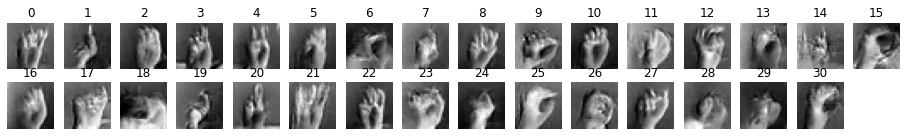

In [10]:
# you can adjust the number of epochs
EPOCHS = 100

# run the training loop and collect images
fake_images = train_gan(gan, image_dataset, random_normal_dimensions, EPOCHS)

In [11]:
# helper function to collect the images
def append_to_grading_images(images, indexes):
  l = []
  for index in indexes:
    if len(l) >= 16:
      print("The list is full")
      break
    l.append(tf.squeeze(images[index:(index+1),...], axis=0))
  l = tf.convert_to_tensor(l)
  return l

In [14]:
grading_images = append_to_grading_images(fake_images, [0,1,2,3,4,5,8,9,10,12,16,20,22,25,27,30])

In [15]:
from PIL import Image
from zipfile import ZipFile

denormalized_images = grading_images * 255
denormalized_images = tf.dtypes.cast(denormalized_images, dtype = tf.uint8)

file_paths = []

for this_image in range(0,16):
  i = tf.reshape(denormalized_images[this_image], [28,28])
  im = Image.fromarray(i.numpy())
  im = im.convert("L")
  filename = "hand" + str(this_image) + ".png"
  file_paths.append(filename)
  im.save(filename)

with ZipFile('my-signs.zip', 'w') as zip:
  for file in file_paths:
    zip.write(file)